# EDA Project (09.04.25 - 14.04.25)
This project is centered around exploratory data analysis techniques and presentation of results to a client.
***

### Client information

|Name|Type|Requirements|
|---|---|---|
|Zachary Brooks| Seller| Invests in historical houses, best neighborhoods, high profits, best timing within a year, should renovate?|

### Hypotheses

|#|Hypothesis|
|---|---|
|1|Big living footage and high grades would give the highest profit|
|2|The best timing within a year for selling would be spring or summer|
|3|Renovation would increase the profit a lot|

***

## Initialization

In [76]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from scipy.stats import ttest_ind

#Remove chain warnings
pd.options.mode.chained_assignment = None

In [77]:
# Load data and keep only needed columns
df_orig  = pd.read_csv("data/eda.csv")

keep_columns = ["id","condition","grade","view","yr_built","yr_renovated","zipcode","long","lat","sqft_living","sqft_lot","date","price"]

df_short = df_orig[keep_columns]
df_short.head(5)

,id,condition,grade,view,yr_built,yr_renovated,zipcode,long,lat,sqft_living,sqft_lot,date,price
0,7129300520,3,7,0.0,1955,0.0,98178,-122.257,47.5112,1180.0,5650.0,2014-10-13,221900.0
1,6414100192,3,7,0.0,1951,19910.0,98125,-122.319,47.7210,2570.0,7242.0,2014-12-09,538000.0
2,5631500400,3,6,0.0,1933,NaN,98028,-122.233,47.7379,770.0,10000.0,2015-02-25,180000.0
3,2487200875,5,7,0.0,1965,0.0,98136,-122.393,47.5208,1960.0,5000.0,2014-12-09,604000.0
4,1954400510,3,8,0.0,1987,0.0,98074,-122.045,47.6168,1680.0,8080.0,2015-02-18,510000.0


## Data cleaning

In [78]:
# Checkout duplicates
df_short.duplicated().value_counts() # -> no duplicates

# Checkout missing values
df_short.isna().sum() # -> Only missing values in yr_renovated which is fine

# change "date" dtype to datetime with format %Y-%m-%d
df_short['date'] = pd.to_datetime(df_short['date'], format='%Y-%m-%d')

# change "yr_renovated" column to an actual year
df_short["yr_renovated"] = (df_short["yr_renovated"].fillna(0)/10).astype("int")

# Add selling month to the dataset
df_short["date_month"] = df_short['date'].dt.month

# Add renovated column which is truw for all houses that have been renovated in the last 3 years
df_short["renovated"] = df_short['date'].dt.year - df_short['yr_renovated']<3
df_short["renovated"] = df_short["renovated"].map({True: "Renovated", False: "Not renovated"})

## Client conditions

### Historcial houses
There is no specific definition for historical houses, so I took the definition from one website (https://www.homeday.de/de/immobilienkauf/altes-haus-kaufen/) to define historical houses. Two building dates can be taken as threshold (1924 and 1949). Since 1924 will remove to many houses, I decided to use 1949.




In [79]:
# Conditions for houses to be historical
cond_hist49 = df_short["yr_built"] <1949

In [112]:
# Location of historical houses in King County

conditions = [(df_short["yr_built"]<=1949) & (df_short["yr_built"]>1924),
              df_short["yr_built"]<=1924,
              df_short["yr_built"]>1949]
choices = ["Built before 1949", "Built before 1924", "Built after 1949"]

df_short['house_age'] = np.select(conditions, choices, default='null')

fig1 = px.scatter_map(df_short, #our dataframe
                      lat=df_short['lat'], #set latitudes
                      lon=df_short['long'], #set longitudes
                      color="house_age",
                      color_discrete_map={"Built after 1949": 'lightgray', "Built before 1949": '#ff7f0e', "Built before 1924": '#1f77b4'},
                      width=600,
                      height=800,
                      hover_data={'lat':False, 'long':False}, #sets additional hovering data (latitude and longitude is True by default)
                      center = {"lat": 47.482796, "lon": -122.090953}, #this sets the center of the US as initial map center
                      zoom =8.7, #initial zoom level
                      labels={"house_age":"Building year"},
                      title="Distribution of historical houses in King County",
                      color_discrete_sequence=["black"]) #color of the dots

fig1.update_layout(
    autosize=False,
    width=800,
    height=700,
)

fig1.show()

This map shows that nearly all historical houses are located on the peninsula left of Lake Washington

### Best neighborhoods
I came up with two ideas for defining best neighborhoods. For the first one, only those houses where neighbors have large lots are in best neighborhoods. For the second definition I asked Chat GPT for nice Neighborhoods and there ZIP codes in King Cpounty. I got a list with Zip codes, which are known as nice quarters.
Finally, I decided to take the second approach

In [81]:
# ZIP code list given by Chat GPT
zip_GPT = [98004, 98005, 98006, 98007, 98033, 98034, 98052, 98074, 98075, 98040, 98027, 98029, 98039, 98056, 98059, 98045, 98116, 98126, 98102, 98109, 98107]
cond_neighbor_zip = df_short["zipcode"].isin(zip_GPT)

### Best profit and timing
To get the most profit out of the house sale there are two questions that must be answered:
1) Which month is the best for selling?
2) Which houses are the most expensive and best graded?

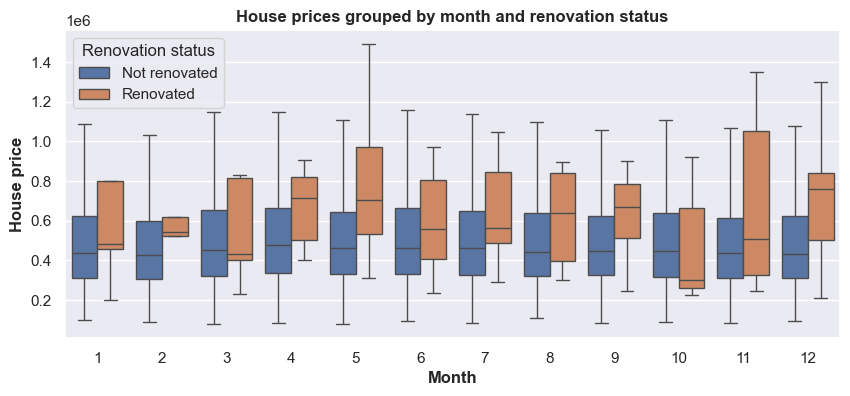

In [82]:
# General selling prices over months grouped by renovated and not renovated within the last 3 years
sns.set_theme(rc={'figure.figsize':(10,4)})
ax = sns.boxplot(df_short, x="date_month",y="price",hue="renovated", showfliers=False)
plt.title("House prices grouped by month and renovation status",weight="bold")
plt.xlabel("Month",weight="bold")
plt.ylabel("House price",weight="bold")
plt.legend(title="Renovation status")
plt.show()

In [83]:
# MISSING DESCRIPTIVE TABLE OF SELLING PRICES BY MONTH AND RESULT

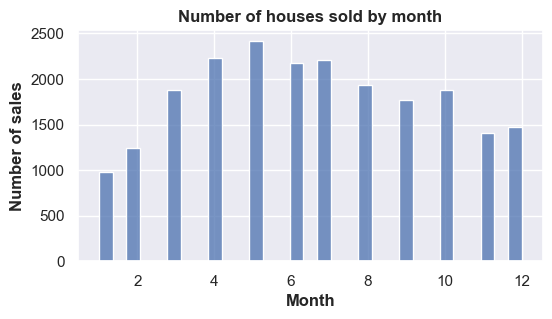

In [84]:
# Amount of houses sold by month
sns.set_theme(rc={'figure.figsize':(6,3)})
sns.histplot(df_short,x="date_month")
plt.title("Number of houses sold by month",weight="bold")
plt.xlabel("Month",weight="bold")
plt.ylabel("Number of sales",weight="bold")
plt.show()

This graphic shows that there have been more house sales in spring and summer than in the winter months.

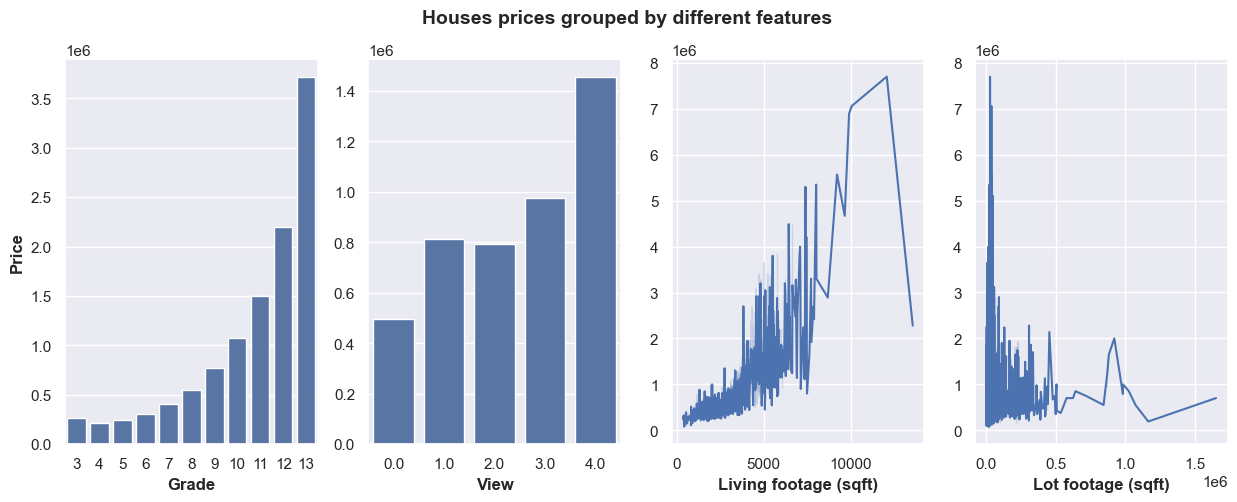

In [104]:
# Histplots for price by grade, footage and view

sns.set_theme(rc={'figure.figsize':(15,5)})
plt.subplot(1,4,1)
sns.barplot(df_short, x="grade", y="price", errorbar=None)
plt.xlabel("Grade",weight="bold")
plt.ylabel("Price",weight="bold")
plt.subplot(1,4,2)
sns.barplot(df_short, x="view", y="price", errorbar=None)
plt.xlabel("View",weight="bold")
plt.ylabel("",weight="bold")
plt.subplot(1,4,3)
sns.lineplot(df_short, x="sqft_living", y="price")
plt.xlabel("Living footage (sqft)",weight="bold")
plt.ylabel("",weight="bold")
plt.subplot(1,4,4)
sns.lineplot(df_short, x="sqft_lot", y="price")
plt.xlabel("Lot footage (sqft)",weight="bold")
plt.ylabel("",weight="bold")
plt.suptitle("Houses prices grouped by different features", fontsize=14, weight="bold")
plt.show()

This figure shows a positive correlation of grades/views/living footage to the selling price of houses. However, lot footage has a negative correlation which is quiet interesting.
To get the best houses with high prices it makes sense to take only houses with the following conditions:
- `grade > 9`
- `view > 2`

These conditions will probably increase number of potential buyers as well.
Living footage will not be taken into account first as bigger houses could have more renovation costs and maybe are not that much in demand.

In [106]:
cond_grade = df_short["grade"]>9
cond_view = df_short["view"]>2

### Renovation
The first graphic in the [previous chapter](#Best-profit-and-timing) already gave an idea that renovated houses always are sold for higher prices than unrenovated houses.
But to be on the save side comparing the means of selling prices for renovated/not renovated houses using a t-test could proof this.

In [60]:
# Significance test that renovated houses can be sold for more money than unrenovated houses
# A p-value smaller than 0.005 would show a significant difference in the mean price
pvalue = ttest_ind(df_short[df_short["renovated"] == "Renovated"]["price"], df_short[df_short["renovated"] == "Not renovated"]["price"]).pvalue
print(f"p-value = {round(pvalue,5)}")
if pvalue<0.05:
    print("-> Renovated houses are significantly more expensive than unrenovated houses")

p-value = 5e-05
-> Renovated houses are significantly more expensive than unrenovated houses


## Results
Considering all results received from the EDA above the following conditions should be applied to get the best fitting houses for the seller
- built before 1949 (historical)
- ZIP codes given by ChatGPT (best neighborhoods)
- grade > 9
- view > 2

In [107]:
# Considering only best fitting houses:
df_best = df_short[cond_hist49 & cond_neighbor_zip & cond_grade & cond_view]
df_best

,id,condition,grade,view,yr_built,yr_renovated,zipcode,long,lat,sqft_living,sqft_lot,date,price,date_month,renovated,house_age
1768,625059051,4,10,3.0,1907,1994,98033,-122.215,47.6878,4370.0,22863.0,2014-09-03,2350000.0,9,Not renovated,Built before 1924
3582,9272200090,4,11,4.0,1910,1977,98116,-122.388,47.5922,3780.0,6000.0,2015-02-04,1600000.0,2,Not renovated,Built before 1924
4631,1324049015,5,10,3.0,1931,0,98040,-122.231,47.5636,3440.0,23954.0,2014-11-11,2490000.0,11,Not renovated,Built before 1949
7245,6762700020,4,13,3.0,1910,1987,98102,-122.323,47.6298,12050.0,27600.0,2014-10-13,7700000.0,10,Not renovated,Built before 1924
7879,3024059014,5,10,3.0,1916,0,98040,-122.210,47.5395,3020.0,11489.0,2015-03-25,1900000.0,3,Not renovated,Built before 1924
8775,3343302110,4,10,4.0,1933,1989,98006,-122.197,47.5466,2790.0,13295.0,2015-03-06,1800000.0,3,Not renovated,Built before 1949
10847,3505100126,4,10,3.0,1910,0,98116,-122.398,47.5815,3760.0,8500.0,2014-06-26,1250000.0,6,Not renovated,Built before 1924
13620,3528900401,4,10,3.0,1913,0,98109,-122.347,47.6406,3140.0,5445.0,2014-07-01,1640000.0,7,Not renovated,Built before 1924
17966,46100504,5,11,3.0,1934,1979,98040,-122.210,47.5648,4100.0,22798.0,2014-06-17,2030000.0,6,Not renovated,Built before 1949
18753,1959701800,5,10,4.0,1909,0,98102,-122.319,47.6465,4660.0,5500.0,2014-07-02,2150000.0,7,Not renovated,Built before 1924


In [110]:
# Show best fitting houses on the map
fig1 = px.scatter_map(df_best,
                      lat=df_best['lat'],
                      lon=df_best['long'],
                      width=600,
                      height=800,
                      hover_data={'lat':False, 'long':False},
                      center = {"lat": 47.622796, "lon": -122.260953},
                      zoom =10,
                      color_discrete_sequence=["black"])

fig1.show()